# Replication of Yoon et al. 2022

This analysis was carried out during a BioFinder group's Reproducibility Retreat which took place at 12-13.04.2024.

Toomas Erik Anijärv

13.04.2024

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import ggseg

from functions.grouping import (determine_amyloid_status, compute_roi_tau,
                                assign_cu_ci_group, find_cutoff_and_plot_roc,
                                is_above_cutoff, check_tau_positivity,
                                assign_at_group)
from functions.stats import (descriptive_stats, categorical_frequencies, anova_posthoc,
                             kruskal_wallis_posthoc, chi_squared_test, ancova_posthoc)
from functions.plotting import (covariates_pairwise_comparison, plot_histogram)

sns.set_theme(context='notebook', style='whitegrid', palette='Accent')

# set working directory
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

### Dataset setup

In [2]:
### demographics

# read demographics and select only relevant columns
demo_fname = os.path.join(data_dir, 'demographics_enrollment.csv')
df_demo = pd.read_csv(demo_fname, low_memory=False)
df_demo = df_demo[df_demo['excluded']!=1]
df_demo = df_demo[['uid', 'sid', 'mid', 'Visit', 'age', 'gender_baseline_variable', 'education_level_years_baseline_variable',
                   'apoe_genotype_baseline_variable', 'study_cohort_baseline_variable']]
df_demo['apoe4_carrier'] = df_demo['apoe_genotype_baseline_variable'].astype(str).str.contains('4').astype(int)

# select only over 50 years of age and E cohort
df_demo = df_demo.loc[df_demo['age']>50]
df_demo = df_demo[(df_demo['study_cohort_baseline_variable'] != 'BF2_E') & (df_demo['study_cohort_baseline_variable'].notna())]

### cognitive staging

# read cognitive staging data and select only relevant columns
cog_fname = os.path.join(data_dir, 'cognitive_staging.csv')
df_cog = pd.read_csv(cog_fname, low_memory=False)
df_cog = df_cog[['uid', 'diagnosis_baseline_variable', 'underlying_etiology_text_baseline_variable', 'cognitive_status_baseline_variable']]
df_cog = df_cog[df_cog['uid'].str.contains('BF')]

# select only normal, SCD, MCI, and AD
df_cog = df_cog[df_cog['diagnosis_baseline_variable'].isin(['Normal', 'SCD', 'MCI', 'AD'])]

# select only with no underlying other etiology (NEED TO DOUBLE CHECK!)
df_cog = df_cog[~df_cog['underlying_etiology_text_baseline_variable'].isin(['Brain Tumor', 'NPH', 'PSP', 'nfvPPA', 
                                                                            'bvFTD', 'CBS', 'MSA', 'PD', 'DLB', np.nan])]

# cognitive tests

# read cognitive tests data and select only relevant columns
cogtest_fname = os.path.join(data_dir, 'cognitive_tests.csv')
df_cogtest = pd.read_csv(cogtest_fname, low_memory=False)
df_cogtest = df_cogtest[['uid', 'mmse_score']]

### tau PET

# read tau PET data
tpet1_fname = os.path.join(data_dir, 'tau_pet_inf_cereb_ref.csv')
df_tpet1 = pd.read_csv(tpet1_fname, low_memory=False)

# define all freesurfer tau PET regions
taupet_all_cols = [col for col in df_tpet1.columns if col.startswith('tnic_sr_mr_fs_ctx_') and 'unknown' not in col] + \
                [col for col in df_tpet1.columns if col.startswith('tnic_sr_mr_fs_') and 'Hippocampus' in col] + \
                [col for col in df_tpet1.columns if col.startswith('tnic_sr_mr_fs_') and 'Amygdala' in col]

# select only these regions and drop subjects with NaN values
df_tpet1 = df_tpet1[['uid', 'tau_pet_date'] + taupet_all_cols].dropna()

# read tau volume PET data
tpet2_fname = os.path.join(data_dir, 'tau_pet_voxelCount.csv')
df_tpet2 = pd.read_csv(tpet2_fname, low_memory=False)

# define all freesurfer tau PET regions
taupet2_all_cols = [col for col in df_tpet2.columns if col.startswith('tnic_vx_fs_ctx') and 'unknown' not in col] + \
                [col for col in df_tpet2.columns if col.startswith('tnic_vx_fs_') and 'Hippocampus' in col] + \
                [col for col in df_tpet2.columns if col.startswith('tnic_vx_fs_') and 'Amygdala' in col]

# select only these regions and drop subjects with NaN values
df_tpet2 = df_tpet2[['uid', 'tau_pet_date'] + taupet2_all_cols].dropna()

# merge both tau PET dataframes
df_tpet = pd.merge(df_tpet1, df_tpet2, how='inner', on=['uid', 'tau_pet_date'])

### amyloid PET

# read in amyloid PET data and select only relevant columns
apet_fname = os.path.join(data_dir, 'amyloid_pet_cerebellar_ref.csv')
df_apet = pd.read_csv(apet_fname, low_memory=False)
df_apet = df_apet[['uid', 'flute_pet_date', 'fnc_ber_com_composite', 'CL_fnc_ber_com_composite']]

### CSF

# read in all CSF data and select only Ab42/Ab40 binary ratio var
csf1_fname = os.path.join(data_dir, 'csf_plasma.csv')
df_csf1 = pd.read_csv(csf1_fname, low_memory=False)
df_csf1 = df_csf1[['uid', 'Abnormal_CSF_Ab42_Ab40_Ratio']]

# read in CSF data and select only relevant columns
csf2_fname = os.path.join(data_dir, 'csf_plasma_primary.csv')
df_csf2 = pd.read_csv(csf2_fname, low_memory=False)
df_csf2 = df_csf2[['uid', 'CSF_ptau181_pgml_Lilly_2019', 'CSF_ptau217_pgml_Lilly_2019',
                   'CSF_Ab42_Ab40_ratio_imputed_Elecsys_2020_2022', 'CSF_Ab42_pgml_imputed_Elecsys_2020_2022']]

# merge both CSF dataframes
df_csf = pd.merge(df_csf1, df_csf2, how='inner', on=['uid'])

### MRI

# read in CSF data and select only relevant columns
mri_fname = os.path.join(data_dir, 'mri_all.csv')
df_mri = pd.read_csv(mri_fname, low_memory=False)
df_mri = df_mri[['uid', 'mri_date', 'aseg_vol_Left_Hippocampus', 'aseg_vol_Right_Hippocampus']]

# calculate average hippocampus volume between two hemispheres
df_mri['aseg_vol_Hippocampus'] = df_mri[['aseg_vol_Left_Hippocampus', 'aseg_vol_Right_Hippocampus']].mean(axis=1)

### merge dataframes

df = df_demo.copy()
df = pd.merge(df, df_cog, how='inner', on='uid')
df = pd.merge(df, df_cogtest, how='inner', on='uid')
df = pd.merge(df, df_tpet, how='inner', on='uid')
df = pd.merge(df, df_apet, how='inner', on='uid')
df = pd.merge(df, df_csf, how='inner', on='uid')
df = pd.merge(df, df_mri, how='inner', on='uid')

# take the first visit only
df = df.loc[df.groupby('sid')['Visit'].idxmin()]

### Cutoff estimation and grouping

Braak 1 cut-off calculation
Optimal cutoff value: 1.3156280528675472
AUC: 0.9341970664422776


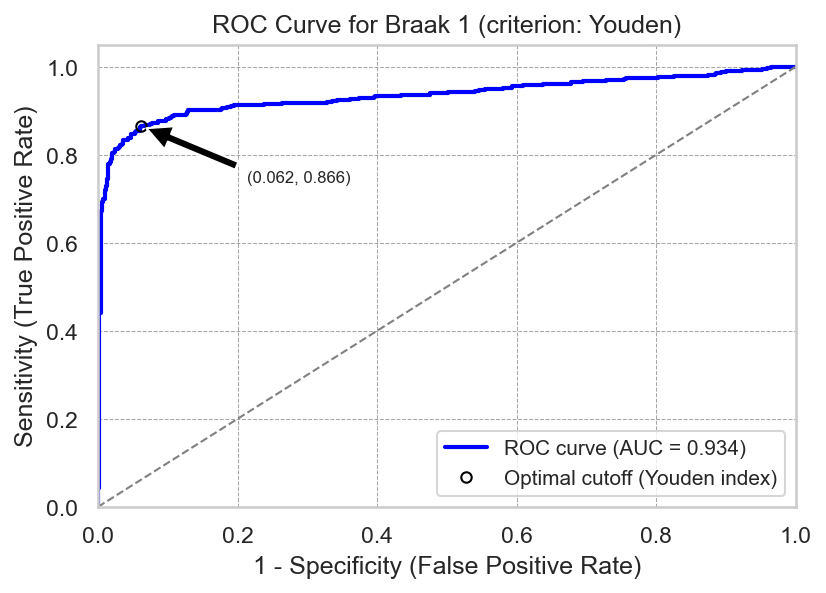

Braak 34 cut-off calculation
Optimal cutoff value: 1.2088830490847093
AUC: 0.9057235724067383


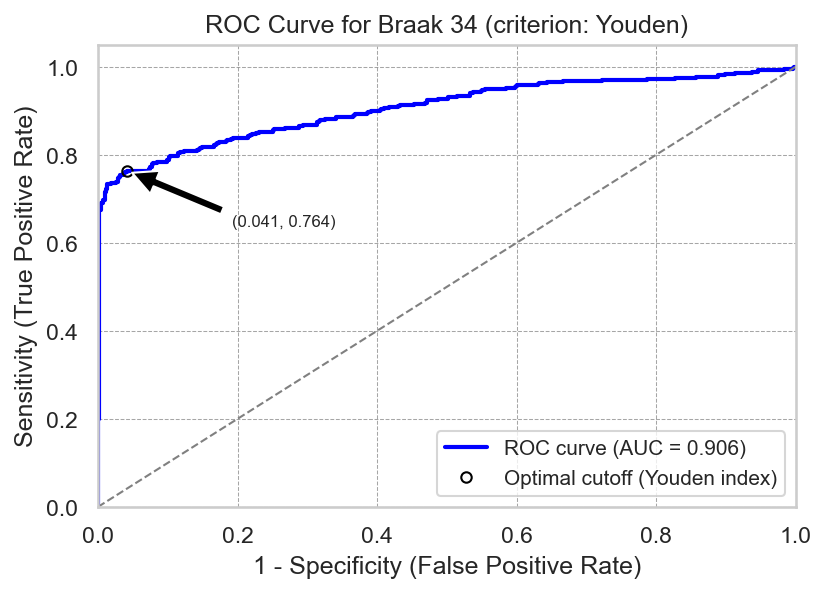

A-T-: 585
A-T+: 66
A+T+: 505


In [3]:
braak1 = ['entorhinal']
braak34 = ['parahippocampal', 'fusiform', 'lingual', 'Amygdala', 'middletemporal', 
           'caudalanteriorcingulate', 'isthmuscingulate', 'rostralanteriorcingulate',
           'posteriorcingulate', 'insula', 'inferiortemporal', 'temporalpole']
braak56 = ['superiorfrontal', 'lateralorbitofrontal', 'medialorbitofrontal', 'frontalpole', ## missing Broca
           'caudalmiddlefrontal', 'rostralmiddlefrontal', 'lateraloccipital', 'supramarginal',
           'inferiorparietal', 'superiorparietal', 'precuneus', 'superiortemporal',
           'bankssts', 'transversetemporal', 'pericalcarine', 'postcentral', 'cuneus',
           'precentral', 'paracentral']
meta_roi = ['entorhinal', 'parahippocampal', 'fusiform', 'Amygdala',
            'inferiortemporal', 'middletemporal']

df = df.copy()

# determine amyloid status
df['amyloid_positive'] = df.apply(determine_amyloid_status, axis=1)

# calculate ROI tau
df['braak1_tau'] = compute_roi_tau(df, braak1, ['_lh_', '_Left', '_rh_', '_Right'])
df['braak34_tau'] = compute_roi_tau(df, braak34, ['_lh_', '_Left', '_rh_', '_Right'])
df['braak56_tau'] = compute_roi_tau(df, braak56, ['_lh_', '_Left', '_rh_', '_Right'])
df['meta_roi_tau'] = compute_roi_tau(df, meta_roi, ['_lh_', '_Left', '_rh_', '_Right'])

# assign to CU or CI group
df['cutoff_group'] = df.apply(assign_cu_ci_group, axis=1)

# calculate the cut-offs for Braak 1 and Braak 34 ROIs
df_roc = df[['cutoff_group', 'braak1_tau', 'braak34_tau']].dropna()
cutoff_braak1, auc_braak1 = find_cutoff_and_plot_roc(df_roc['cutoff_group'].to_numpy(), df_roc['braak1_tau'].to_numpy(), 
                                                     roi_name='Braak 1', plot_roc=True)
cutoff_braak34, auc_braak34 = find_cutoff_and_plot_roc(df_roc['cutoff_group'].to_numpy(), df_roc['braak34_tau'].to_numpy(), 
                                                     roi_name='Braak 34', plot_roc=True)

# check whether participants' Braak 1 and Braak 34 values are above the cut-off for the corresponding ROI
df['is_braak1'] = is_above_cutoff(df['braak1_tau'], cutoff_braak1)
df['is_braak34'] = is_above_cutoff(df['braak34_tau'], cutoff_braak34)

# check tau positivity based on Braak 1 or Braak 34
df['tau_positive'] = df.apply(check_tau_positivity, axis=1)

# assign to AT groups
df['at_group'] = df.apply(assign_at_group, axis=1)
df = df.dropna(subset=['at_group'])
print(f"A-T-: {len(df[df['at_group']=='A-T-'])}")
print(f"A-T+: {len(df[df['at_group']=='A-T+'])}")
print(f"A+T+: {len(df[df['at_group']=='A+T+'])}")

### Descriptives analysis

In [4]:
# sns.histplot(data=df, x='CL_fnc_ber_com_composite', hue='at_group')

In [5]:
group_col = 'at_group'
kruskal_vars = ['age']
anova_vars = ['education_level_years_baseline_variable']
ancova1_vars = ['mmse_score']
ancova2_vars = ['aseg_vol_Hippocampus', 'CL_fnc_ber_com_composite', 'CSF_ptau181_pgml_Lilly_2019', 
               'CSF_Ab42_Ab40_ratio_imputed_Elecsys_2020_2022', 'CSF_Ab42_pgml_imputed_Elecsys_2020_2022']
chi2_vars = ['gender_baseline_variable', 'diagnosis_baseline_variable', 'apoe4_carrier']

# get descriptive statistics
desc_stats = descriptive_stats(df, group_col, kruskal_vars+anova_vars+ancova1_vars+ancova2_vars)
display(desc_stats.T)

# get frequencies for categorical variables
freq_tables = categorical_frequencies(df, group_col, chi2_vars)
for var, table in freq_tables.items():
    display(table)


0            1  \
at_group                                                    A+T+         A-T+   
age                                           mean     73.348082    74.549146   
                                              std       7.197618      8.77293   
                                              count          505           66   
education_level_years_baseline_variable       mean     12.605967    12.765152   
                                              std       4.145745     3.663982   
                                              count          486           66   
mmse_score                                    mean     24.333333    28.606061   
                                              std       4.534822     1.263436   
                                              count          504           66   
aseg_vol_Hippocampus                          mean   3065.653564  3405.998485   
                                              std     480.549983   505.019136   
                                              count          505           66   
CL_fnc_ber_com_composite                      mean     81.455678    -5.479737   
                                              std      34.266539     6.723543   
                                              count          269           65   
CSF_ptau181_pgml_Lilly_2019                   mean    182.388104       57.326   
                                              std     100.495214     33.67938   
                                              count          211           20   
CSF_Ab42_Ab40_ratio_imputed_Elecsys_2020_2022 mean      0.047918     0.108072   
                                              std       0.013582      0.02276   
                                              count          456           61   
CSF_Ab42_pgml_imputed_Elecsys_2020_2022       mean    898.651257  2308.517554   
                                              std     319.350565   905.437131   
                                              count          456           61   

                                                               2  
at_group                                                    A-T-  
age                                           mean     66.028864  
                                              std      10.336189  
                                              count          585  
education_level_years_baseline_variable       mean     12.819204  
                                              std       3.469815  
                                              count          578  
mmse_score                                    mean     28.695726  
                                              std       1.503329  
                                              count          585  
aseg_vol_Hippocampus                          mean   3733.042201  
                                              std     489.896923  
                                              count          577  
CL_fnc_ber_com_composite                      mean     -7.252678  
                                              std       6.035382  
                                              count          572  
CSF_ptau181_pgml_Lilly_2019                   mean     41.923607  
                                              std      18.035026  
                                              count          244  
CSF_Ab42_Ab40_ratio_imputed_Elecsys_2020_2022 mean      0.108269  
                                              std        0.01978  
                                              count          523  
CSF_Ab42_pgml_imputed_Elecsys_2020_2022       mean    2037.12058  
                                              std     744.664133  
                                              count          523

at_group,A+T+,A-T+,A-T-,All
gender_baseline_variable,,,,
0.0,225,32,272,529
1.0,280,34,313,627
All,505,66,585,1156


at_group,A+T+,A-T+,A-T-,All
diagnosis_baseline_variable,,,,
AD,235,0,0,235
MCI,162,18,99,279
Normal,48,34,367,449
SCD,60,14,119,193
All,505,66,585,1156


at_group,A+T+,A-T+,A-T-,All
apoe4_carrier,,,,
0,150,56,385,591
1,355,10,200,565
All,505,66,585,1156


In [6]:
# Chi2 tests for categorical vars
for var in chi2_vars:
    chi_squared_test(df, group_col, var)

# Kruskal-Wallis (not normally distributed vars)
for var in kruskal_vars:
    kruskal_wallis_posthoc(df, group_col, var)

# ANOVAs
for var in anova_vars:
    anova_posthoc(df, group_col, var)

# ANCOVAs with age, sex, education as covariates
covars = ['age', 'gender_baseline_variable', 'education_level_years_baseline_variable']
for var in ancova1_vars:
    ancova_posthoc(df, var, factor_var='at_group', covariates=covars)

# ANCOVAs with age, sex, education as covariates
covars = ['age', 'gender_baseline_variable', 'diagnosis_baseline_variable']
for var in ancova2_vars:
    ancova_posthoc(df, var, factor_var='at_group', covariates=covars)


Chi-Squared test result for gender_baseline_variable:
Chi2-statistic: 0.6207, p-value: 0.7332, dof: 2

Chi-Squared test result for diagnosis_baseline_variable:
Chi2-statistic: 542.1112, p-value: 0.0000, dof: 6

Chi-Squared test result for apoe4_carrier:
Chi2-statistic: 173.2856, p-value: 0.0000, dof: 2

Kruskal-Wallis result for age:
H-statistic: 149.8746, p-value: 0.0000
Post-hoc pairwise Mann-Whitney U tests for age:
A+T+ vs A-T-: U-statistic=207962.0000, p-value=0.0000 (Bonferroni corrected)
A+T+ vs A-T+: U-statistic=14487.5000, p-value=0.2524 (Bonferroni corrected)
A-T+ vs A-T-: U-statistic=28194.0000, p-value=0.0000 (Bonferroni corrected)

ANOVA result for education_level_years_baseline_variable:


,sum_sq,df,F,PR(>F)
C(at_group),12.121374,2.0,0.422797,0.655316
Residual,16155.259378,1127.0,NaN,NaN



ANCOVA result for mmse_score:


,sum_sq,df,F,PR(>F)
C(at_group),4547.258922,2.0,228.610447,4.975733e-84
age,0.067865,1.0,0.006824,9.341796e-01
gender_baseline_variable,0.059437,1.0,0.005976,9.383932e-01
education_level_years_baseline_variable,207.091349,1.0,20.822762,5.591813e-06
Residual,11178.664627,1124.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for mmse_score:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=2.574123 (Bonferroni corrected)

ANCOVA result for aseg_vol_Hippocampus:


,sum_sq,df,F,PR(>F)
C(at_group),7.033470e+06,2.0,22.155392,3.633502e-10
diagnosis_baseline_variable,2.496285e+07,3.0,52.421904,9.648982e-32
age,4.636278e+07,1.0,292.085054,1.781117e-58
gender_baseline_variable,1.970389e+07,1.0,124.134279,1.938897e-27
Residual,1.809527e+08,1140.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for aseg_vol_Hippocampus:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.614821 (Bonferroni corrected)
A-T- vs A-T+: p=0.155932 (Bonferroni corrected)

ANCOVA result for CL_fnc_ber_com_composite:


,sum_sq,df,F,PR(>F)
C(at_group),966006.917322,2.0,1345.485420,6.911569e-271
diagnosis_baseline_variable,13729.334739,3.0,12.748439,3.652340e-08
age,1269.802430,1.0,3.537243,6.032851e-02
gender_baseline_variable,1364.701880,1.0,3.801601,5.151451e-02
Residual,322364.775791,898.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for CL_fnc_ber_com_composite:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=1.413901 (Bonferroni corrected)

ANCOVA result for CSF_ptau181_pgml_Lilly_2019:


,sum_sq,df,F,PR(>F)
C(at_group),4.411549e+05,2.0,54.575528,5.014771e-22
diagnosis_baseline_variable,3.208496e+05,3.0,26.461659,8.003817e-16
age,5.677974e+03,1.0,1.404851,2.365159e-01
gender_baseline_variable,3.957778e+03,1.0,0.979238,3.228995e-01
Residual,1.887470e+06,467.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for CSF_ptau181_pgml_Lilly_2019:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.004187 (Bonferroni corrected)
A-T- vs A-T+: p=0.037848 (Bonferroni corrected)

ANCOVA result for CSF_Ab42_Ab40_ratio_imputed_Elecsys_2020_2022:


,sum_sq,df,F,PR(>F)
C(at_group),0.419623,2.0,691.324900,3.206127e-191
diagnosis_baseline_variable,0.005799,3.0,6.369330,2.809993e-04
age,0.000206,1.0,0.678921,4.101488e-01
gender_baseline_variable,0.000031,1.0,0.101263,7.503838e-01
Residual,0.313204,1032.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for CSF_Ab42_Ab40_ratio_imputed_Elecsys_2020_2022:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=2.823420 (Bonferroni corrected)

ANCOVA result for CSF_Ab42_pgml_imputed_Elecsys_2020_2022:


,sum_sq,df,F,PR(>F)
C(at_group),1.721593e+08,2.0,239.105477,4.734934e-86
diagnosis_baseline_variable,3.362944e+06,3.0,3.113775,2.551283e-02
age,8.331979e+06,1.0,23.143931,1.726913e-06
gender_baseline_variable,1.382785e+06,1.0,3.840994,5.028267e-02
Residual,3.715273e+08,1032.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for CSF_Ab42_pgml_imputed_Elecsys_2020_2022:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=0.292145 (Bonferroni corrected)


### Tau level comparisons

In [7]:
tau_cols = ['braak1_tau', 'braak34_tau', 'braak56_tau', 'meta_roi_tau']
covars = ['age', 'gender_baseline_variable', 'education_level_years_baseline_variable']
for var in tau_cols:
    ancova_posthoc(df, dependent_var=var, factor_var='at_group', covariates=covars)


ANCOVA result for braak1_tau:


,sum_sq,df,F,PR(>F)
C(at_group),131.462348,2.0,937.697974,2.739499e-240
age,0.015538,1.0,0.221666,6.378650e-01
gender_baseline_variable,0.157126,1.0,2.241508,1.346307e-01
education_level_years_baseline_variable,0.119883,1.0,1.710210,1.912256e-01
Residual,78.790657,1124.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for braak1_tau:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=0.000000 (Bonferroni corrected)

ANCOVA result for braak34_tau:


,sum_sq,df,F,PR(>F)
C(at_group),72.425682,2.0,375.161269,1.556521e-125
age,1.199445,1.0,12.426127,4.404079e-04
gender_baseline_variable,0.011537,1.0,0.119518,7.296229e-01
education_level_years_baseline_variable,0.225030,1.0,2.331291,1.270780e-01
Residual,108.495297,1124.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for braak34_tau:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=0.000000 (Bonferroni corrected)

ANCOVA result for braak56_tau:


,sum_sq,df,F,PR(>F)
C(at_group),35.885651,2.0,267.645291,8.595104e-96
age,3.434534,1.0,51.231442,1.479051e-12
gender_baseline_variable,0.146442,1.0,2.184407,1.396949e-01
education_level_years_baseline_variable,0.101243,1.0,1.510195,2.193666e-01
Residual,75.352479,1124.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for braak56_tau:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=0.000000 (Bonferroni corrected)

ANCOVA result for meta_roi_tau:


,sum_sq,df,F,PR(>F)
C(at_group),133.060653,2.0,402.555124,1.445459e-132
age,1.775917,1.0,10.745541,1.077308e-03
gender_baseline_variable,0.061034,1.0,0.369299,5.435096e-01
education_level_years_baseline_variable,0.308581,1.0,1.867129,1.720775e-01
Residual,185.763595,1124.0,NaN,NaN


Performing pairwise comparisons with Bonferroni correction for meta_roi_tau:
A+T+ vs A-T-: p=0.000000 (Bonferroni corrected)
A+T+ vs A-T+: p=0.000000 (Bonferroni corrected)
A-T- vs A-T+: p=0.000000 (Bonferroni corrected)


TO-DO: 
- edit the stats tests inside to take the p values as argument
- change to violinplots

Total participants = 1156
A-T- participants = 585
A+T+ participants = 505
A-T+ participants = 66


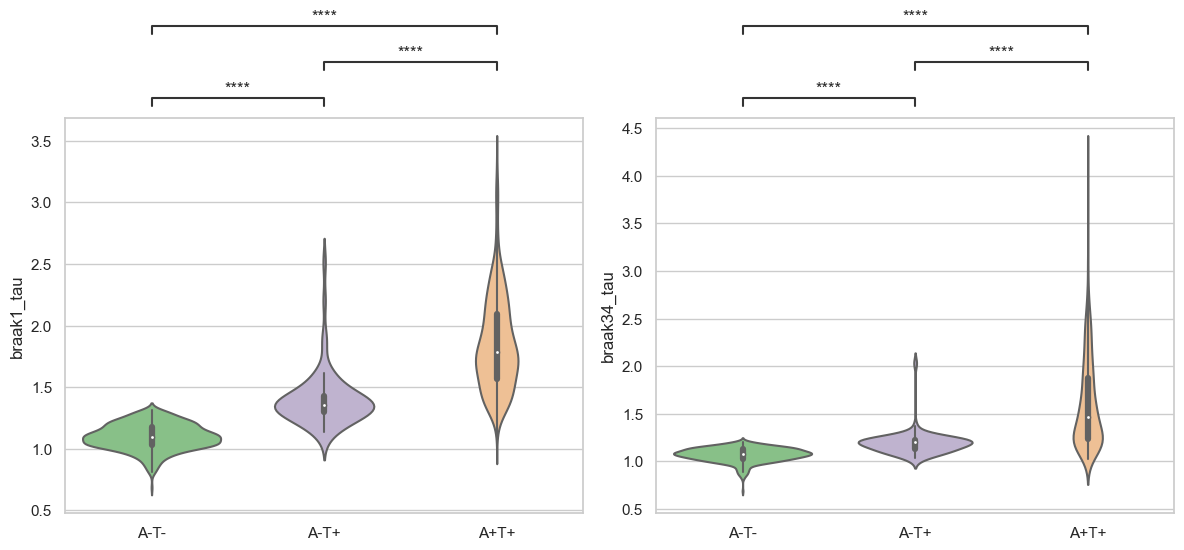

Total participants = 1156
A-T- participants = 585
A+T+ participants = 505
A-T+ participants = 66


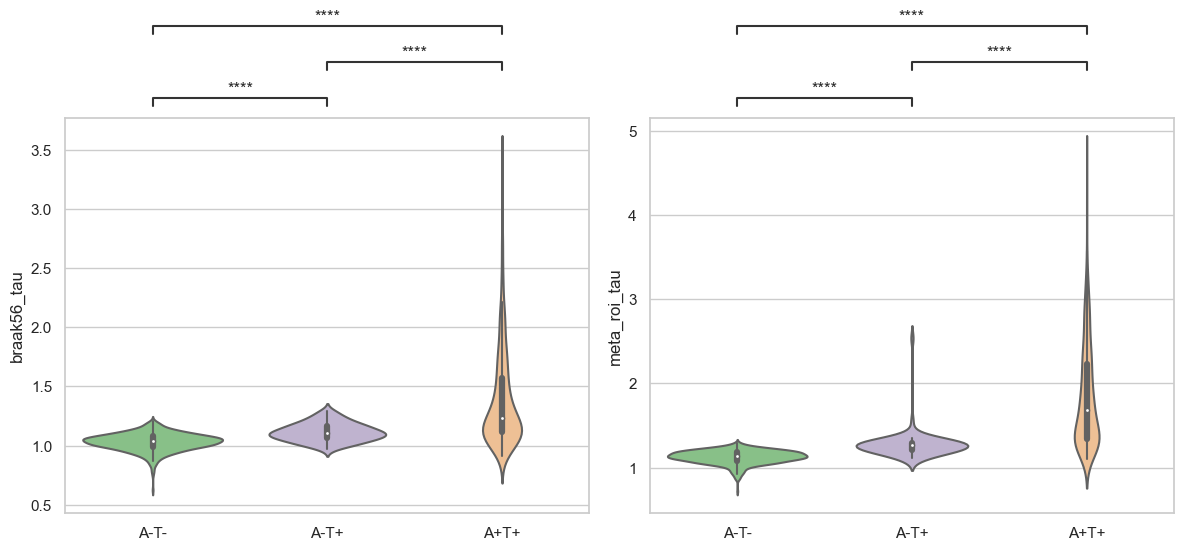

In [8]:
covariates_pairwise_comparison(df, 'at_group', cont_vars=['braak1_tau', 'braak34_tau'], cat_vars=[], plot_title=None,
                               group_order=['A-T-', 'A-T+', 'A+T+'])
covariates_pairwise_comparison(df, 'at_group', cont_vars=['braak56_tau', 'meta_roi_tau'], cat_vars=[], plot_title=None,
                               group_order=['A-T-', 'A-T+', 'A+T+'])

### Tau deposition topography

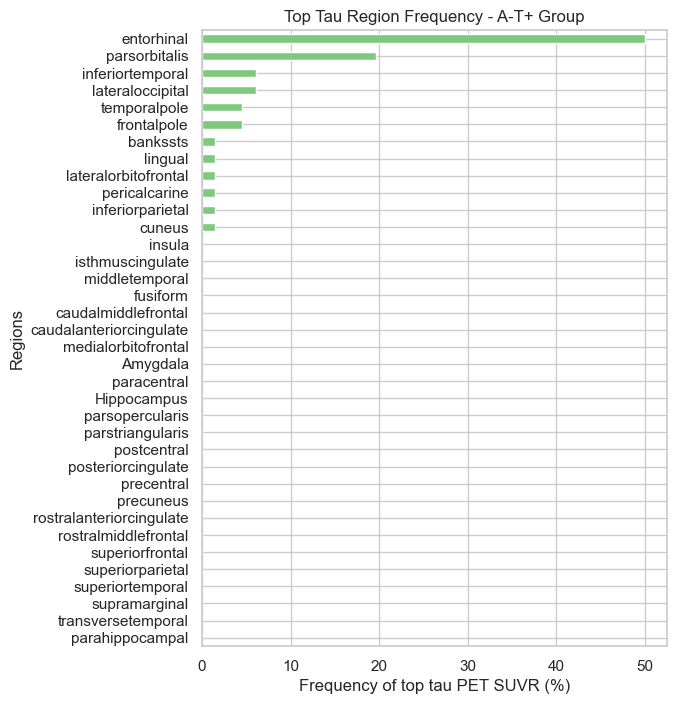

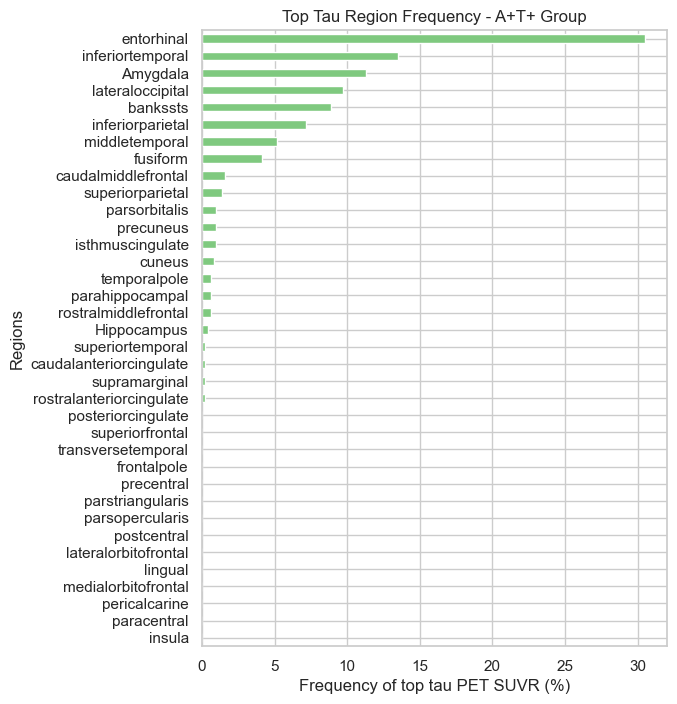

In [9]:
# define left and right hemisphere columns
left_cols = [col for col in taupet_all_cols if '_lh_' in col or '_Left_' in col]
right_cols = [col for col in taupet_all_cols if '_rh_' in col or '_Right_' in col]

def clean_column_name(col):
    """Helper function to standardize the column names by removing side identifiers"""
    col = col.replace('_lh_', '_').replace('_Left_', '_').replace('_rh_', '_').replace('_Right_', '_')
    return col.rsplit('_', 1)[1]

# create a mapping of right hemisphere columns to their corresponding left hemisphere names
right_to_left_mapping = {clean_column_name(right_col): right_col for right_col in right_cols}

# for the averaging, ensure matching right hemisphere column for each left hemisphere column
df_avg = pd.DataFrame()
for left_col in left_cols:
    cleaned_left_col_name = clean_column_name(left_col)
    if cleaned_left_col_name in right_to_left_mapping:
        right_col = right_to_left_mapping[cleaned_left_col_name]
        region_name = cleaned_left_col_name
        df_avg[region_name] = (df[left_col] + df[right_col]) / 2

# find the top region by the averaged hemispheres
df['top_avg_region'] = df_avg.idxmax(axis=1)

# get the list of all regions
all_regions = list(right_to_left_mapping.keys())

# plotting histogram for each AT group
for group in ['A-T+', 'A+T+']:
    group_data = df[df['at_group'] == group]
    top_regions_group_freq = group_data['top_avg_region'].value_counts(normalize=True) * 100
    plot_histogram(top_regions_group_freq, f'Top Tau Region Frequency - {group} Group', all_regions)


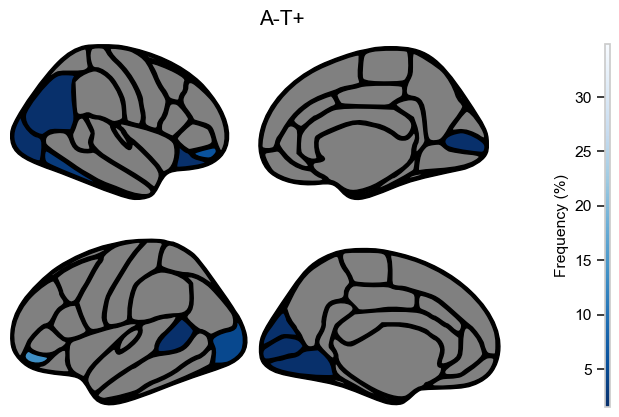

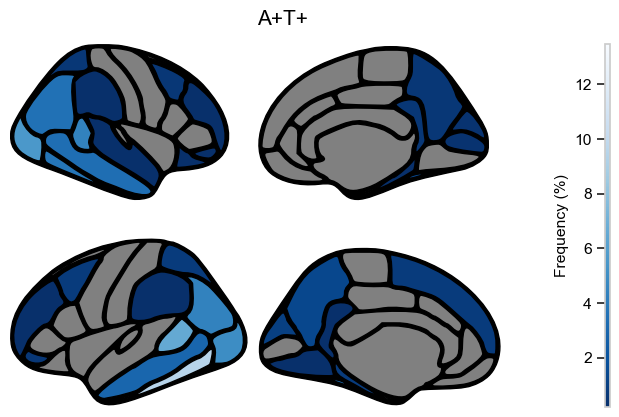

In [10]:
def format_region_name(region_name):
    """Helper function to map the full column name to the short name format"""
    if '_lh_' in region_name or '_Left_' in region_name:
        short_name = region_name.split('_')[-1] + '_left'
    elif '_rh_' in region_name or '_Right_' in region_name:
        short_name = region_name.split('_')[-1] + '_right'
    else:
        short_name = region_name  # Adjust as necessary
    return short_name.lower()

# get top tau regions and format region names
df['top_tau_region'] = df[taupet_all_cols].idxmax(axis=1)
df['top_tau_region_formatted'] = df['top_tau_region'].apply(format_region_name)

# calculate the frequency of each region being the top region and save as dict
for group in ['A-T+', 'A+T+']:
    group_data = df[df['at_group'] == group]
    top_regions_group_freq = group_data['top_tau_region_formatted'].value_counts(normalize=True) * 100
    region_frequency_dict = top_regions_group_freq.to_dict()

    ggseg.plot_dk(region_frequency_dict, cmap='Blues_r', background='white', edgecolor='black',
              bordercolor='black', figsize=(6, 6), ylabel='Frequency (%)', title=group)